<a href="https://colab.research.google.com/github/galb4tosha/my-ml/blob/master/Flowers_classification_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [0]:
from PIL import Image
import numpy as np
import pandas as pd
from time import time
import keras
from keras.applications import MobileNetV2
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam, Adadelta
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.regularizers import l2

import random
import gc
!pip install Augmentor
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
import Augmentor

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('/gdrive/My Drive/data/flower.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:

IMG_SIZE = 224
IMG_HEIGHT = 224



ATTR = ['Type']

In [0]:
df_attr = pd.read_csv('/gdrive/My Drive/data/attr.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.shape
images_folder ='train/'

In [0]:
def load_reshape_img(fname):
  
    img = load_img(fname)  
    x = img_to_array(img)/255.
    x = cv2.resize(x,(IMG_WIDTH,IMG_HEIGHT),3)    
    x = x.reshape((1,) + x.shape)
    
    return x

In [0]:
model = MobileNetV2(alpha=0.35,weights='imagenet',include_top=False,input_shape=(224, 224, 3))

In [0]:
#Adding custom Layers
x = model.output 
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation="relu",W_regularizer=l2(0.0001))(x) 
x = Dropout(0.3)(x) 
x = Dense(512, activation="relu",W_regularizer=l2(0.0001))(x) 
predictions = Dense(102, activation="softmax")(x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, activation="relu", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_regularizer=<keras.reg...)`
  """


In [0]:
# create the second model 
model2 = Model(inputs=model.input, outputs=predictions)

#Lock initial layers to not be trained
for layer in model.layers[:52]:
   layer.trainable = False
    
# Check the status of the layers 
#for layer in InceptionV3model.layers:
 #   print(layer, layer.trainable)  
    
    
    
    
# Show a summary of the model. Check the number of trainable parameters
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

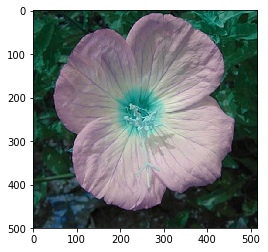

In [0]:
import os
CATEGORIES = []
DATADIR = "/content/train"

for i in range(1,103):
  CATEGORIES.append(str(i))


for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [0]:
from tqdm import tqdm
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                print("aaa")
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()
print(len(training_data))

 77%|███████▋  | 76/99 [00:00<00:00, 245.75it/s]

aaa


100%|██████████| 107/107 [00:00<00:00, 283.88it/s]

13998


In [0]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)


print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 3))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X = X/255.0

print(X)

[[[[ 13  43  27]
   [  4  43  22]
   [  9  57  34]
   ...
   [ 44 118 107]
   [ 24  94  82]
   [ 27  96  83]]

  [[ 16  51  35]
   [  9  51  30]
   [ 11  61  38]
   ...
   [ 23 102  87]
   [ 29 104  88]
   [ 33 107  91]]

  [[ 10  51  33]
   [  3  50  28]
   [ 13  63  41]
   ...
   [ 27 109  89]
   [ 30 113  91]
   [ 32 115  92]]

  ...

  [[ 32  47  49]
   [ 21  35  33]
   [ 25  35  31]
   ...
   [ 15  13  12]
   [ 16  18  18]
   [ 13  18  17]]

  [[ 41  45  44]
   [ 26  32  31]
   [ 19  28  27]
   ...
   [ 21  19  19]
   [ 17  15  14]
   [ 21  19  17]]

  [[ 33  33  33]
   [ 18  23  22]
   [ 16  24  23]
   ...
   [ 23  22  21]
   [ 24  20  19]
   [ 27  23  22]]]]


In [0]:
model2.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='sparse_categorical_crossentropy'
                    , metrics=['accuracy'])

W0710 09:35:32.875475 140501432776576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
#13
model2.fit(X, y, batch_size=16, epochs=10, validation_split=0.1)

W0710 09:35:33.049089 140501432776576 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6633 samples, validate on 737 samples
Epoch 1/10
6633/6633 [==============================] - 67s 10ms/step - loss: 4.5288 - acc: 0.0320 - val_loss: 5.1103 - val_acc: 0.0000e+00
Epoch 2/10
6633/6633 [==============================] - 62s 9ms/step - loss: 4.0955 - acc: 0.1345 - val_loss: 5.6131 - val_acc: 0.0000e+00
Epoch 3/10
6633/6633 [==============================] - 62s 9ms/step - loss: 3.6010 - acc: 0.2352 - val_loss: 6.1690 - val_acc: 0.0000e+00
Epoch 4/10
6633/6633 [==============================] - 61s 9ms/step - loss: 3.0684 - acc: 0.3581 - val_loss: 6.8082 - val_acc: 0.0000e+00
Epoch 5/10
6633/6633 [==============================] - 62s 9ms/step - loss: 2.5307 - acc: 0.4716 - val_loss: 7.5265 - val_acc: 0.0000e+00
Epoch 6/10
6633/6633 [==============================] - 62s 9ms/step - loss: 2.0589 - acc: 0.5601 - val_loss: 8.2618 - val_acc: 0.0041
Epoch 7/10
6633/6633 [==============================] - 61s 9ms/step - loss: 1.6729 - acc: 0.6355 - val_loss: 8.9552 - val

In [0]:
def load_reshape_img(fname): 

  img = load_img(fname) 
  x = img_to_array(img)/255. 
  x = cv2.resize(x,(224,224),3) 
  x = x.reshape((1,) + x.shape) 

  return x

In [0]:
np.argmax(model2.predict([load_reshape_img('/gdrive/My Drive/data/rose2.JPG')]))+1
#model2.predict([load_reshape_img('/gdrive/My Drive/data/rose.jpg')])

28

In [0]:
res = model2.predict([load_reshape_img('/gdrive/My Drive/rose2.JPG')]) 
top = sorted(res[0], reverse=True)[0:3] 
top_index = [] 
for i in top: 
top_index.append((res[0].tolist()).index(i)+1) 
print(top) 
print(top_index) 
#np.argmax(model2.predict([load_reshape_img('/gdrive/My Drive/magn.jpg')]))+1 
#model2.predict([load_reshape_img('/gdrive/My Drive/data/rose.jpg')])

In [0]:
#model2.save('/content/my_model.h5') 
new_model = keras.models.load_model('/content/my_model.h5') 
new_model.summary()

In [0]:
from tensorflow import lite 
converter = lite.TFLiteConverter.from_keras_model_file( 'my_model.h5' ) 
model = converter.convert() 
file = open( 'model.lite' , 'wb' ) 
file.write( model )
